In [88]:
#%matplotlib notebook
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import quad
from deepRD.noiseSampler import binnedData
import deepRD.tools.trajectoryTools as trajectoryTools
import deepRD.tools.analysisTools as analysisTools
matplotlib.rcParams.update({'font.size': 15})
colorList = ['CC6677', '882255', 'AA4499','332288', '88CCEE', '44AA99','117733', '999933', 'DDCC77']
colorList2 = ['4477AA', 'EE6677', '228833', 'CCBB44', '66CCEE', 'AA3377', 'BBBBBB']
colorList3 = ['0077BB', '33BBEE', '009988', 'EE7733', 'CC3311', 'EE3377', 'BBBBBB']
colorList3alt = ['EE7733', 'A50026', '0077BB', '009988', '33BBEE', 'BBBBBB']
colorList3alt2 = ['A50026', '0077BB', '009988', '33BBEE', 'BBBBBB', 'EE7733']
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=colorList3alt2)

In [89]:
# Benchmark data folderhttp://localhost:8888/notebooks/stochasticClosure/03_plotComparisonDimer.ipynb#
boxsize = 5
parentDirectory = os.environ.get('DATA') + 'stochasticClosure/dimer/boxsize' + str(boxsize) + '/benchmarkComparisonBias/'
benchmarkfnamebase = parentDirectory + 'simMoriZwanzig_'
# Reduced models data folders
localDataDirectory = os.environ.get('DATA') + 'stochasticClosure/dimerGlobal/boxsize' + str(boxsize) + '/benchmarkReduced'
numModels = 30
redModelfnamebase = [localDataDirectory]*numModels
redModelfnamebase[0] += '_ri/simMoriZwanzigReduced_'
redModelfnamebase[1] += '_ririm/simMoriZwanzigReduced_'
redModelfnamebase[2] += '_qi/simMoriZwanzigReduced_'
redModelfnamebase[3] += '_qiri/simMoriZwanzigReduced_'
redModelfnamebase[4] += '_qiririm/simMoriZwanzigReduced_'
redModelfnamebase[5] += '_pi/simMoriZwanzigReduced_'
redModelfnamebase[6] += '_piri/simMoriZwanzigReduced_'
redModelfnamebase[7] += '_piririm/simMoriZwanzigReduced_'
redModelfnamebase[8] += '_qipi/simMoriZwanzigReduced_'
redModelfnamebase[9] += '_qipiri/simMoriZwanzigReduced_'
redModelfnamebase[10] += '_qipiririm/simMoriZwanzigReduced_'
redModelfnamebase[11] += '_dqi/simMoriZwanzigReduced_'
redModelfnamebase[12] += '_dqiri/simMoriZwanzigReduced_'
redModelfnamebase[13] += '_dqiririm/simMoriZwanzigReduced_'
redModelfnamebase[14] += '_pidqi/simMoriZwanzigReduced_'
redModelfnamebase[15] += '_pidqiri/simMoriZwanzigReduced_'
redModelfnamebase[16] += '_pidqiririm/simMoriZwanzigReduced_'
redModelfnamebase[17] += '_dpi/simMoriZwanzigReduced_'
redModelfnamebase[18] += '_dpiri/simMoriZwanzigReduced_'
redModelfnamebase[19] += '_dpiririm/simMoriZwanzigReduced_'
redModelfnamebase[20] += '_dqidpi/simMoriZwanzigReduced_'
redModelfnamebase[21] += '_dqidpiri/simMoriZwanzigReduced_'
redModelfnamebase[22] += '_dqidpiririm/simMoriZwanzigReduced_'
redModelfnamebase[23] += '_dpivi/simMoriZwanzigReduced_'
redModelfnamebase[24] += '_dpiviri/simMoriZwanzigReduced_'
redModelfnamebase[25] += '_dpiviririm/simMoriZwanzigReduced_'
redModelfnamebase[26] += '_vi/simMoriZwanzigReduced_'
redModelfnamebase[27] += '_viri/simMoriZwanzigReduced_'
redModelfnamebase[28] += '_viririm/simMoriZwanzigReduced_'

In [3]:
# Read relevant parameters
parameterDictionary = analysisTools.readParameters(parentDirectory + "parameters")
numSimulations = 50 #parameterDictionary['numFiles']
dt = parameterDictionary['dt'] 
integratorStride = parameterDictionary['stride']
totalTimeSteps = parameterDictionary['timesteps'] 
boxsize = parameterDictionary['boxsize']
boundaryType = parameterDictionary['boundaryType']
parameterDictionary

{'numFiles': 100,
 'numParticles': 502,
 'dt': 0.05,
 'bodytype': 'point',
 'Gamma': 0.3,
 'sigma': 0.44544935907016964,
 'KbT': 1,
 'mass': 54.0,
 'timesteps': 200000,
 'stride': 1,
 'trajtype': 'moriZwanzigVelocity',
 'boxsize': 8,
 'boundaryType': 'periodic',
 'equilibrationSteps': 10000}

## Load benchmark and reduced model trajectory data

In [4]:
# Load benchmark trajectory data from h5 files (only of distinguished particle)
trajs_ref = []
print("Loading benchmark data ...")
for i in range(numSimulations):
    traj = trajectoryTools.loadTrajectory(benchmarkfnamebase, i)
    trajs_ref.append(traj)    
    print("File ", i+1, " of ", numSimulations, " done.", end="\r")
print("Benchmark data loaded.")

Loading benchmark data ...
Benchmark data loaded..


In [5]:
# Load reduced model trajectory data from h5 files (only of distinguished particle)
allTrajs = [None]*numModels
print("Loading reduced models data ...")
for i in range(numModels):
    try:
        iTraj = []
        for j in range(numSimulations):
            traj = trajectoryTools.loadTrajectory(redModelfnamebase[i], j)
            iTraj.append(traj)
            print("File ", j+1, " of ", numSimulations, " done.", end="\r")
        allTrajs[i] = iTraj
    except:
        continue
print("Reduced models data loaded.")

Loading reduced models data ...
Reduced models data loaded.


## Computations on data

In [6]:
# Choose which reduced model to compare (just uncomment one)
conditionedList = ['pi','piri', 'piririm'] #['dqi','dqiri', 'dqiririm'] #Possibilities 'dqi', 'dpi', 'dvi, 'ri', 'qiri', 'qiririm'
trajIndexes = []
if 'ri' in conditionedList:
    trajIndexes.append(0)
if 'ririm' in conditionedList:
    trajIndexes.append(1)
if 'qi' in conditionedList:
    trajIndexes.append(2)
if 'qiri' in conditionedList:
    trajIndexes.append(3)
if 'qiririm' in conditionedList:
    trajIndexes.append(4)
if 'pi' in conditionedList:
    trajIndexes.append(5)
if 'piri' in conditionedList:
    trajIndexes.append(6)
if 'piririm' in conditionedList:
    trajIndexes.append(7)
if 'qipi' in conditionedList:
    trajIndexes.append(8)
if 'qipiri' in conditionedList:
    trajIndexes.append(9)
if 'qipiririm' in conditionedList:
    trajIndexes.append(10)
if 'dqi' in conditionedList:
    trajIndexes.append(11)
if 'dqiri' in conditionedList:
    trajIndexes.append(12)
if 'dqiririm' in conditionedList:
    trajIndexes.append(13)
if 'pidqi' in conditionedList:
    trajIndexes.append(14)
if 'pidqiri' in conditionedList:
    trajIndexes.append(15)
if 'pidqiririm' in conditionedList:
    trajIndexes.append(16)
if 'dpi' in conditionedList:
    trajIndexes.append(17)
if 'dpiri' in conditionedList:
    trajIndexes.append(18)
if 'dpiririm' in conditionedList:
    trajIndexes.append(19)
if 'dqidpi' in conditionedList:
    trajIndexes.append(20)
if 'dqidpiri' in conditionedList:
    trajIndexes.append(21)
if 'dqidpiririm' in conditionedList:
    trajIndexes.append(22)
if 'dpivi' in conditionedList:
    trajIndexes.append(23)
if 'dpiviri' in conditionedList:
    trajIndexes.append(24)
if 'dpiviririm' in conditionedList:
    trajIndexes.append(25)
if 'vi' in conditionedList:
    trajIndexes.append(26)
if 'viri' in conditionedList:
    trajIndexes.append(27)
if 'viririm' in conditionedList:
    trajIndexes.append(28)

numConditions = len(trajIndexes)
# Note in plot labels x = q and v = p
labelList = [r'$\tilde{r}_{i+1}|\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{r}_i, \tilde{r}_{i-1}$',
             r'$\tilde{r}_{i+1}|\tilde{x}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{x}_i,\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{x}_i, \tilde{r}_i, \tilde{r}_{i-1}$',
             r'$\tilde{r}_{i+1}|\tilde{v}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{v}_i,\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{v}_i, \tilde{r}_i, \tilde{r}_{i-1}$', 
             r'$\tilde{r}_{i+1}|\tilde{x}_i, \tilde{v}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{x}_i, \tilde{v}_i, \tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{x}_i, \tilde{v}_i, \tilde{r}_i, \tilde{r}_{i-1}$',
             r'$\tilde{r}_{i+1}|\Delta\tilde{x}_i$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{x}_i,\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{x}_i, \tilde{r}_i, \tilde{r}_{i-1}$',
             r'$\tilde{r}_{i+1}|\tilde{v}_i,\Delta\tilde{x}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{v}_i,\Delta\tilde{x}_i,\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{v}_i,\Delta\tilde{x}_i, \tilde{r}_i, \tilde{r}_{i-1}$',
             r'$\tilde{r}_{i+1}|\Delta\tilde{v}_i$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{v}_i,\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{v}_i, \tilde{r}_i, \tilde{r}_{i-1}$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{x}_i \Delta\tilde{v}_i$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{x}_i \Delta\tilde{v}_i,\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{x}_i \Delta\tilde{v}_i, \tilde{r}_i, \tilde{r}_{i-1}$',
             r'$\tilde{r}_{i+1}|\Delta\tilde{v}_i, v_i^{CM}$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{v}_i, v_i^{CM}, \tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\Delta\tilde{v}_i, v_i^{CM}, \tilde{r}_i, \tilde{r}_{i-1}$',
             r'$\tilde{r}_{i+1}|\tilde{v_R}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{v_R}_i,\tilde{r}_i$', 
             r'$\tilde{r}_{i+1}|\tilde{v_R}_i, \tilde{r}_i, \tilde{r}_{i-1}$']
lwList = [2, 2, 2]*2
lineTypeList = ['-.', '--', 'xk']*2
#lwList = [2, 2, 2, 2]*2
#lineTypeList = [':', '-.', '--', 'xk']*2

In [7]:
# Extract reference trajectories of the two particles
trajs1_ref = trajectoryTools.extractParticleTrajectories(trajs_ref,0,2)
trajs2_ref = trajectoryTools.extractParticleTrajectories(trajs_ref,1,2)
# Extract reduced model trajectories of the two particles
allTrajs1 = [None] * numModels 
allTrajs2 = [None] * numModels
for i in range(numModels):
    if allTrajs[i] != None:
        allTrajs1[i] = trajectoryTools.extractParticleTrajectories(allTrajs[i],0,2)
        allTrajs2[i] = trajectoryTools.extractParticleTrajectories(allTrajs[i],1,2)

In [8]:
position1 = [None] * numConditions
position2 = [None] * numConditions
velocity1 = [None] * numConditions
velocity2 = [None] * numConditions
for i in range(numConditions):
    currentTrajs1 = allTrajs1[trajIndexes[i]]
    currentTrajs2 = allTrajs2[trajIndexes[i]]
    position1[i] = trajectoryTools.extractVariableFromTrajectory(currentTrajs1, variableIndex=[1, 4])
    position2[i] = trajectoryTools.extractVariableFromTrajectory(currentTrajs2, variableIndex=[1, 4])
    velocity1[i] = trajectoryTools.extractVariableFromTrajectory(currentTrajs1, variableIndex=[4, 7])
    velocity2[i] = trajectoryTools.extractVariableFromTrajectory(currentTrajs2, variableIndex=[4, 7])
    print('Done', i+1 , ' out of ', numConditions + 1)
position1_ref = trajectoryTools.extractVariableFromTrajectory(trajs1_ref, variableIndex=[1, 4])
position2_ref = trajectoryTools.extractVariableFromTrajectory(trajs2_ref, variableIndex=[1, 4])
velocity1_ref = trajectoryTools.extractVariableFromTrajectory(trajs1_ref, variableIndex=[4, 7])
velocity2_ref = trajectoryTools.extractVariableFromTrajectory(trajs2_ref, variableIndex=[4, 7])
print('Done')

Done 1  out of  4
Done 2  out of  4
Done 3  out of  4
Done


In [9]:
# Function to calculate relative positions in periodic box of edge size bsize
def relativePosition(positions1, positions2, bsize):
    relPositions = []
    for j in range(len(positions1)):
        pos1 = positions1[j]
        pos2 = positions2[j]
        p1periodic = 1.0 * pos1
        for i in range(3):
            if (pos2[i] - pos1[i]) > 0.5 * bsize:
                p1periodic[i] += bsize
            if (pos2[i] - pos1[i]) < -0.5 * bsize:
                p1periodic[i] -= bsize
        relPositions.append(pos2 - p1periodic)
    return np.array(relPositions)

def relativeDistance(positions1, positions2, bsize):
    relDistances = []
    for j in range(len(positions1)):
        pos1 = positions1[j]
        pos2 = positions2[j]
        p1periodic = 1.0 * pos1
        for i in range(3):
            if (pos2[i] - pos1[i]) > 0.5 * bsize:
                p1periodic[i] += bsize
            if (pos2[i] - pos1[i]) < -0.5 * bsize:
                p1periodic[i] -= bsize
        relDistances.append(np.linalg.norm(pos2 - p1periodic))
    return np.array(relDistances)

def relativeSpeed(velocities1, velocities2):
    relSpeeds = []
    for j in range(len(velocities1)):
        vel1 = velocities1[j]
        vel2 = velocities2[j]
        relSpeeds.append(np.linalg.norm(vel2 - vel1))
    return np.array(relSpeeds)

def relativeDistanceOrientation(positions1, positions2, bsize):
    relDistances = []
    orientations = []
    for j in range(len(positions1)):
        pos1 = positions1[j]
        pos2 = positions2[j]
        p1periodic = 1.0 * pos1
        for i in range(3):
            if (pos2[i] - pos1[i]) > 0.5 * bsize:
                p1periodic[i] += bsize
            if (pos2[i] - pos1[i]) < -0.5 * bsize:
                p1periodic[i] -= bsize
        relPosition = pos2 - p1periodic
        relDistances.append(np.linalg.norm(relPosition))
        orientations.append(relPosition/np.linalg.norm(relPosition))
    return np.array(relDistances), np.array(orientations)

In [10]:
# Calculate relative distances
relDist = [None] * numConditions
relSpeed = [None] * numConditions
orientation = [None] * numConditions
relDist_ref, orientation_ref = relativeDistanceOrientation(position1_ref,position2_ref, boxsize)
relSpeed_ref = relativeSpeed(velocity1_ref,velocity2_ref)
for i in range(numConditions):
    relDist[i], orientation[i] = relativeDistanceOrientation(position1[i],position2[i], boxsize)
    relSpeed[i] = relativeSpeed(velocity1[i],velocity2[i])
    print('Done', i+1 , ' out of ', numConditions)

Done 1  out of  3
Done 2  out of  3
Done 3  out of  3


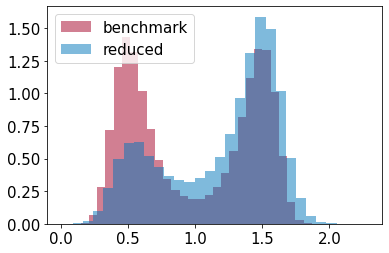

In [11]:
# Fast plot
plt.hist(relDist_ref, bins = 30, alpha = 0.5, label = 'benchmark', density=True)
plt.hist(relDist[0], bins = 30, alpha = 0.5, label = 'reduced', density=True)
plt.legend()

## Distribution plots comparisons

In [40]:
sum(velocity1_ref[:,0]<-1.5)

0

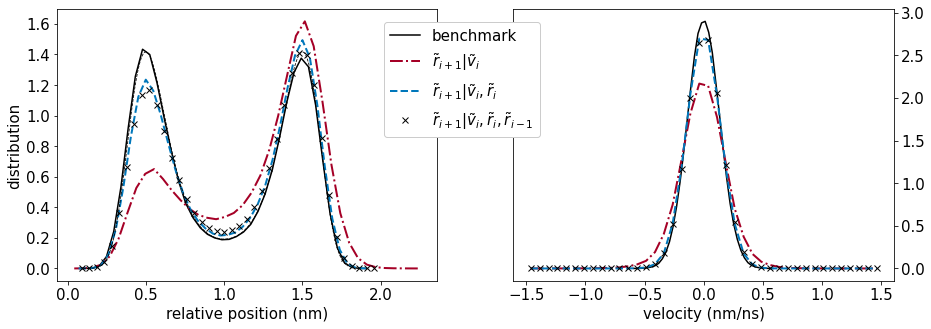

In [44]:
# Plot distribution comparisons|

# Create plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5)) #fig, ax = plt.subplots()
numbins = 40

# Plot relative position distribution
pos_ref, binEdges_ref = np.histogram(relDist_ref, bins=numbins, density = True)
binsPos_ref = 0.5 * (binEdges_ref[1:] + binEdges_ref[:-1])
ax1.plot(binsPos_ref, pos_ref, '-k', label = 'benchmark');
for i in range(numConditions):
    index = trajIndexes[i]
    pos, binEdges = np.histogram(relDist[i], bins=numbins, density = True)
    binsPos = 0.5 * (binEdges[1:] + binEdges[:-1])
    ax1.plot(binsPos, pos, lineTypeList[i], lw = lwList[i], label = labelList[index]);

    
# Plot ideal case analytic solution
def integrand(x,x0,rad,scale):
    return np.exp(-scale * (1 - ((x - (x0 + rad))/rad)**2 )**2) 
particleDiameter = 0.5
x0 = 1.0*particleDiameter # location of first minima
rad = 1.0*particleDiameter # half the distance between minimas
scale = 2
C0,error = quad(integrand, -np.inf, np.inf, args=(x0,rad,scale))
x = np.arange(0.1,1.8,0.01)
idealP = integrand(x,x0,rad,scale)/C0
ax1.plot(x,idealP,'--k',lw=0.8,label= 'Dimer ideal \n distribution')
    
# Plot velocity distribution of one of the two particles
vel_ref, binEdges_ref = np.histogram(velocity1_ref[:,0], bins=numbins, density = True)
binsVel_ref = 0.5 * (binEdges_ref[1:] + binEdges_ref[:-1])
ax2.plot(binsVel_ref, vel_ref, '-k', label = 'benchmark');
for i in range(numConditions):
    index = trajIndexes[i]
    vel, binEdges = np.histogram(velocity1[i][:,0], bins=numbins, density = True)
    #vel, binEdges = np.histogram(velocity1[i][:,0], range=(-1.5,1.5),  bins=numbins, density = True)
    binsVel = 0.5 * (binEdges[1:] + binEdges[:-1])
    ax2.plot(binsVel, vel, lineTypeList[i], lw = lwList[i], label = labelList[index]);

#ax1.legend()

ax1.set_xlabel("relative position (nm)");
ax1.set_ylabel("distribution");
#ax1.set_xlim([0,2])
#ax1.set_ylim([0,2])
ax2.set_xlabel("velocity (nm/ns)");
ax2.yaxis.tick_right()
#ax2.set_xlim([-1.4,1.4]) #([-1,1])
#ax1.set_ylim([-0.2,2.5])
ax2.legend(loc = 'lower left',  bbox_to_anchor=(-0.36, 0.5), framealpha = 1.0);
plt.savefig('dimer_distributions_comparison_global_bias_box' + str(boxsize) + '.pdf')
#plt.savefig('dimer_distributions_comparison_global_bias_box' + str(boxsize) + '_ideal.pdf')

## Plot auto-correlation functions comparison

In [13]:
#def autoCorrelationFromTimeSeries(timeSeriesData, lagtime=1):
#    mean = np.mean(timeSeriesData)
#    variance = np.var(timeSeriesData)
#    AC = 0.0
#    for i in range(len(timeSeriesData)-lagtime):
#        devFromMean = timeSeriesData[i] - mean
#        devFromMean2 = timeSeriesData[i + lagtime] - mean
#        AC += np.dot(devFromMean, devFromMean2)
#    AC = AC/(len(timeSeriesData)-lagtime)
#    AC = AC/variance
#    return AC
    
# def autoCorrelationFunctionFromTimeSeries(timeSeriesData, lagtimesteps, stride = 1):
#     '''
#     Calculates autocorrelation function of time series data, for a given lagtimesteps (length of time interval in
#     timesteps) and stride.
#     '''
#     ACF = []
#     for lagtime in range(lagtimesteps):
#         ACF.append(autoCorrelationFromTimeSeries(timeSeriesData, lagtime*stride + 1))
#         print('Computing ACF: ', 100*(lagtime+1)/lagtimesteps , '% complete   ', end="\r")
#     ACF = np.array(ACF)
#     return ACF

In [49]:
# Autocorrelation for relative distance
lagtimesteps = 400
acf_stride = 5 #10
ACF_ref_relpos = trajectoryTools.autoCorrelationFunctionFromTimeSeries(relDist_ref,lagtimesteps,acf_stride)
ACF_ref_relvel = trajectoryTools.autoCorrelationFunctionFromTimeSeries(relSpeed_ref,lagtimesteps,acf_stride)
ACF_relpos = [None]*numConditions
ACF_relvel = [None]*numConditions
for i in range(numConditions):
    ACF_relpos[i] = trajectoryTools.autoCorrelationFunctionFromTimeSeries(relDist[i],lagtimesteps,acf_stride)
    ACF_relvel[i] = trajectoryTools.autoCorrelationFunctionFromTimeSeries(relSpeed[i],lagtimesteps,acf_stride)

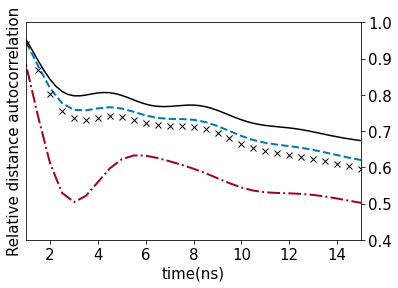

In [85]:
f, (ax1) = plt.subplots(1, 1, figsize=(6,4)) #fig, ax = plt.subplots()
time = dt*integratorStride*acf_stride*np.linspace(1,lagtimesteps,lagtimesteps)
ax1.plot(time, ACF_ref_relpos, '-k', label = 'benchmark')
# Plot reduced models
sampleStep = 2
for i in range(numConditions):
    index = trajIndexes[i]
    time_resampled = time[1::sampleStep] # resample to only plot every 10th or so point
    ACF_relpos_resampled = ACF_relpos[i][1::sampleStep]
    ax1.plot(time_resampled, ACF_relpos_resampled, lineTypeList[i], lw = lwList[i], label = labelList[index])
ax1.set_xlabel('time(ns)')
ax1.set_ylabel('Relative distance autocorrelation')
ax1.yaxis.tick_right()
ax1.set_xlim([1,15])
ax1.set_ylim([0.4,1])
#ax1.legend()
plt.savefig('relativeDistance_autocorr_global_bias_box' + str(boxsize) + '_zoom.pdf')

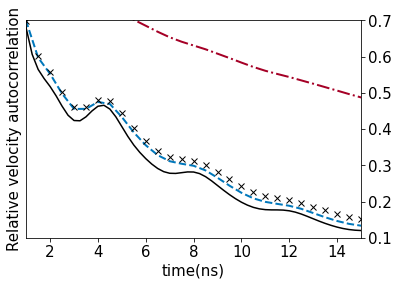

In [87]:
f, (ax1) = plt.subplots(1, 1, figsize=(6,4)) #fig, ax = plt.subplots()
time = dt*integratorStride*acf_stride*np.linspace(1,lagtimesteps,lagtimesteps)
ax1.plot(time, ACF_ref_relvel, '-k', label = 'benchmark')
# Plot reduced models
for i in range(numConditions):
    index = trajIndexes[i]
    time_resampled = time[1::sampleStep] # resample to only plot every 10th or so point
    ACF_relvel_resampled = ACF_relvel[i][1::sampleStep]
    ax1.plot(time_resampled, ACF_relvel_resampled, lineTypeList[i], lw = lwList[i], label = labelList[index])
ax1.set_xlabel('time(ns)')
ax1.set_ylabel('Relative velocity autocorrelation')
ax1.yaxis.tick_right()
ax1.set_xlim([1,15])
ax1.set_ylim([0.1,0.7])
#ax1.legend()
plt.savefig('relativeVelocity_autocorr_global_bias_box' + str(boxsize) + '_zoom.pdf')

In [17]:
# Autocorrelation for orientation
lagtimesteps = 40
acf_stride = 10
ACF_ref_orientation = trajectoryTools.autoCorrelationFunctionFromTimeSeries(orientation_ref[:,0],lagtimesteps,acf_stride)
ACF_relorientation = [None]*numConditions
for i in range(numConditions):
    ACF_relorientation[i] = trajectoryTools.autoCorrelationFunctionFromTimeSeries(orientation[i][:,0],lagtimesteps,acf_stride)

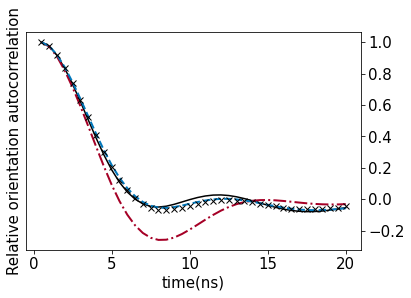

In [18]:
f, (ax1) = plt.subplots(1, 1, figsize=(6,4)) #fig, ax = plt.subplots()
time = dt*integratorStride*acf_stride*np.linspace(1,lagtimesteps,lagtimesteps)
ax1.plot(time, ACF_ref_orientation, '-k', label = 'benchmark')
# Plot reduced models
for i in range(numConditions):
    index = trajIndexes[i]
    ax1.plot(time, ACF_relorientation[i], lineTypeList[i], lw = lwList[i], label = labelList[index])
ax1.set_xlabel('time(ns)')
ax1.set_ylabel('Relative orientation autocorrelation')
ax1.yaxis.tick_right()
#ax1.legend()
plt.savefig('relativeOrientation_autocorr_global_bias_box' + str(boxsize) + '.pdf')

In [19]:
# Calculate reference autocorrelation functions or position and velocity of particle 1
lagtimesteps = 40
stridesPos = 50
stridesVel = 50
stridesAux = 1 
print('ACF for reference benchmark:')
ACF_ref_position = trajectoryTools.autoCorrelationFunctionFromTimeSeries(position1_ref[:,0], lagtimesteps, stridesPos)
ACF_ref_velocity = trajectoryTools.autoCorrelationFunctionFromTimeSeries(velocity1_ref[:,0], lagtimesteps, stridesVel)

ACF for reference benchmark:


In [20]:
# Calculate autocorrelation functions for reduced models
ACF_position = [None] * numConditions
ACF_velocity = [None] * numConditions
for i in range(numConditions):
    print('\nACF conditioned on ' + conditionedList[i] + ' (' + str(i+1) + ' of ' + str(numConditions) + '):')
    currentTrajs = allTrajs[trajIndexes[i]]
    ACF_position[i] = trajectoryTools.autoCorrelationFunctionFromTimeSeries(position1[i][:,0], 
                                                                            lagtimesteps, stridesPos)
    ACF_velocity[i] = trajectoryTools.autoCorrelationFunctionFromTimeSeries(velocity1[i][:,0],
                                                                            lagtimesteps, stridesVel)
    print('\nDone')


ACF conditioned on pi (1 of 3):
Computing ACF:  100.0 % complete   
Done

ACF conditioned on piri (2 of 3):
Computing ACF:  100.0 % complete   
Done

ACF conditioned on piririm (3 of 3):
Computing ACF:  100.0 % complete   
Done


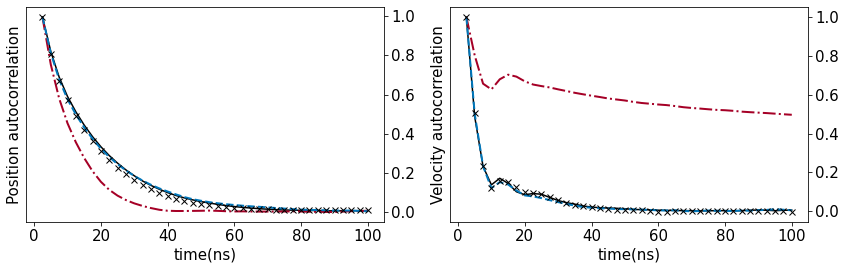

In [21]:
# Plot three autocorrelation functions at once
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4)) #fig, ax = plt.subplots()
time = dt*integratorStride*stridesPos*np.linspace(1,lagtimesteps,lagtimesteps)
ax1.plot(time, ACF_ref_position, '-k', label = 'benchmark')
# Plot reduced models
for i in range(numConditions):
    index = trajIndexes[i]
    ax1.plot(time, ACF_position[i], lineTypeList[i], lw = lwList[i], label = labelList[index])
ax1.set_xlabel('time(ns)')
ax1.set_ylabel('Position autocorrelation')
ax1.yaxis.tick_right()


time = dt*integratorStride*stridesVel*np.linspace(1,lagtimesteps,lagtimesteps)
# Plot reference
ax2.plot(time, ACF_ref_velocity, '-k', label = 'benchmark')
# Plot reduced models
for i in range(numConditions):
    index = trajIndexes[i]
    ax2.plot(time, ACF_velocity[i], lineTypeList[i], lw = lwList[i], label = labelList[index])
ax2.set_xlabel('time(ns)')
ax2.set_ylabel('Velocity autocorrelation')
ax2.yaxis.tick_right()

plt.tight_layout()
plt.savefig('posVel_autocorr_global_bias_box' + str(boxsize) + '.pdf')

## Plot FPTs distributions (not implemented yet)

In [ ]:
transition = 'OC'
boxs = 5
fname1 = os.environ['DATA'] + 'stochasticClosure/dimer/boxsize' + str(boxs) + '/benchmarkFPTcomparison/simMoriZwanzigFPTs_'+ transition + '_box' + str(boxs) + '_nsims' +'10000.xyz'
fname2 = os.environ['DATA'] + 'stochasticClosure/dimerGlobal/boxsize' + str(boxs) + '/benchmarkFPTreduced/simMoriZwanzigFPTs_'+ transition + '_' + conditionedOn + '_box' + str(boxs) +'_10000.xyz'

In [ ]:
# Load data from files
file1 = open(fname1, "r")
#file2 = open(fname2, "r")

# Read files and save to array
filelines = file1.readlines()
benchmarkFPT = np.zeros(len(filelines), dtype = int)
for i, line in enumerate(filelines):
    benchmarkFPT[i] = int(float(line))
filelines = file2.readlines()
benchmarkFPTreduced = np.zeros(len(filelines), dtype = int)
for i, line in enumerate(filelines):
    benchmarkFPTreduced[i] = int(float(line))

In [ ]:
numbins = 50
plt.hist(benchmarkFPT, numbins, alpha = 0.5, density=True, label='benchmark')
plt.hist(benchmarkFPTreduced, numbins, alpha = 0.5, density=True, label='reduced')
plt.legend()

In [ ]:
np.mean(benchmarkFPT)

In [ ]:
np.max(benchmarkFPT)

In [ ]:
np.mean(benchmarkFPTreduced)

In [ ]:
len(benchmarkFPT)

In [ ]:
len(benchmarkFPTreduced)